# HBOMS epi model example

In this notebook, we show a simple SEIR-model example with multiple units. These units might correspond to different communities in which a pathogen spreads, isolated by space (or time, or otherwise).

We first have to import the `hboms` package, which provides the building blocks for defining a model.
We also import some utilities (for displaying stan models with syntax highlighting), and some other python modules for statistics and plotting.

In [1]:
import hboms
import hboms.utilities as util
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts

## Vaccination data

Here I assume that the vaccination data can be transformed in a per-capita vaccination rate.
This rate is modeled as a smoothed, piece-wise constant function, with levels that are
unit-specific, but with change points (knots) that are the same for all units.

The smoothed rate function is given by

$$ 
\eta(t) = \sum_{i=1}^{n-1} \eta_i \mathrm{expit}(t - \tau_i) [1 - \mathrm{expit}(t - \tau_{i+1})] 
$$

where $n$ is the number of knots.
This is slightly inefficient, as for $t$ far away from $\tau_i$ and $\tau_{i+1}$ the expit terms are practically zero.

We set the first and last knot $\tau_1$ and $\tau_n$ to values way beyond the observed interval. Notice that outside the interval $[\tau_1, \tau_n]$, the vaccination rate is very close to zero.
For this example, the time interval is going to be $t \in [0, 120]$ days, and we choose $\tau_1 = -20$ and $\tau_n = 140$. 

Text(0, 0.5, 'vaccination rate (per capita)')

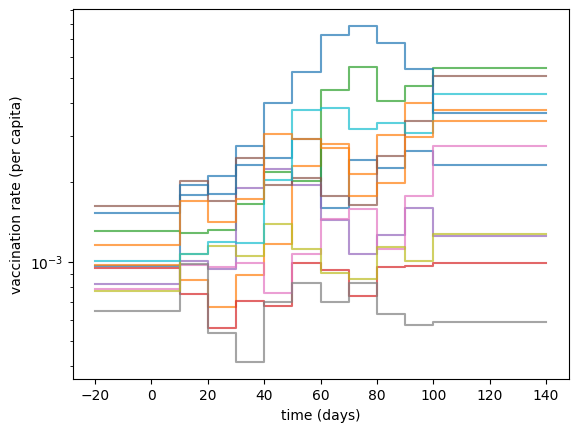

In [2]:
## vaccination rates 

R = 12 # number of units
knots = np.array([-20] + [10*i for i in range(1,11)] + [140])
num_knots = len(knots)

vacc_rates = [
    0.001 * np.exp(np.cumsum(sts.norm.rvs(size=num_knots-1, loc=0.1, scale=0.3)))
    for _ in range(R)
]

fig, ax = plt.subplots(1, 1)

for vr in vacc_rates:
    vre = list(vr) + [vr[-1]]
    ax.step(knots, vre, where='post', alpha=0.7)

ax.set_yscale('log')
ax.set_xlabel("time (days)")
ax.set_ylabel("vaccination rate (per capita)")

## Define an HBOMS model

Every HBOMS model has the following obligatory components:

* a list of parameters. A parameter has to be defined with the `Parameter` class from the `hboms` module. The `Parameter` class has 3 required arguments: `name`, `value` and `type`. The name must be unique, the value is the initial guess and the type determines if the parameter is a constant, fixed between units, or varies between units.
* A list of state variables. Use `Variable` objects from the `hboms` module to create these state variables. It is possible to define vector-valued state variables, but this is still experimental. This should make it easy to define e.g. age classes in epi models.
* A string defing the ODE model. This is regular Stan code, and can contain any Stan expression or statement. The ODE model will have access to all the unit-specific or shared parameters used in this piece of code. At this point, non-constant parameters have to be scalars. Constants *are* allowed to be vectors or matrices. In addition to parameters, the ODE function has access to the state variables by name. For each state variable `X`, a variable `ddt_X` is declared, and the user is supposed to define these time derivatives.
* A string defining the initial condition. The user has automatic access to the parameters, and for each state variable `X`, an initial value `X_0` is declared, which the user must define.
* A list of distributions defining the model likelihood. Distributions are defined using the `StanDist` class, which takes the name of a Stan distribution as its first argument, then the name of the observation and then a list of parameters. The parameters can be arbitrary Stan expressions.
* Finally, a list of observations must be given. Use `Observation` from the `hboms` module to create these. The data type (in this case an integer) must be specified, as the default is a real number.

In addition to these, we can also specify optional components. In our case

* `trans_state`, which is a list of additional state variables, which can be computed from the ODE state variables.
* `transform` a string with Stan statements specifying how to compute the transformed state variables.
* `options` is a python `dict` with some integration options. It specifies the ODE integrator tolerance parameters etc. The option `unit_obs` is a boolean which must be set to `True` is you have any observations at time `t=0`. This is because Stan by default does not allow evaluation of the ODEs at t=0, and we add some code to circumvent this.

Some things to avoid:

* Don't use the names `R`, `r`, `N`, `n`, `u_sim` `state`. It's probably a bad idea to start variables with `ddt_` or end them with `_0` or `_sim`. There are currently no warnings when you violate these rules.

We can choose from the following parameter types. The "H" in HBOMS is currently only justified by the `random` parameter.

* `random`: random-effects like parameter. Normal or log-Normal distribution with estimated location and scale parameters.
* `fixed`: parameter shared between all units.
* `indiv`: Different parameter for each unit. Location and scale not estimated.
* `const`: A constant shared by all units
* `const_indiv`: A constant that is different for all units.

The space in which a parameter lives can be 
* `real`: this is the default and valid for all parameters
* `vector`: Currently only implemented for `const` and `const_indiv` parameters. The dimension of the vector space must be the same for each unit. So you might have to add some padding.
* `matrix` The same restrictions hold as for `vector`.

In [3]:
# parameters are positive by default. set lbound=None to avoid this.
params = [
    hboms.Parameter("R0m1", 0.5, "random", scale=0.15), # R_0 - 1
    hboms.Parameter("alpha", 0.5, "const"), # rate E -> I
    hboms.Parameter("gamma", 0.4, "random", scale=0.1), # recovery rate
    hboms.Parameter("theta", 300, "const"), # scale to population size
    hboms.Parameter("epsilon", 1e-4, "const"), # inoculum size
    hboms.Parameter("phi", 1e3, "fixed"), # overdispersion parameter
    hboms.Parameter("eta", vacc_rates, "const_indiv", space="vector"), # per-capita vaccination rate
    hboms.Parameter("tau", knots, "const", lbound=None, space="vector"), # vacc-rate change points
]

# the variable V is the cumulative fraction of vaccinated individuals
state = [
    hboms.Variable("S"), 
    hboms.Variable("E"), 
    hboms.Variable("I"), 
    hboms.Variable("V")
]

# beta and gamma are correlated. Does it help to reparameterize with R0m1 = beta / gamma - 1?
odes = """
real beta = gamma * (R0m1 + 1);
int n = num_elements(tau);
real vacc_rate = sum(eta .* inv_logit(t - tau[1:n-1]) .* inv_logit(tau[2:n] - t));
ddt_S = -beta * S * I - vacc_rate * S;
ddt_E = beta * S * I - alpha * E;
ddt_I = alpha * E - gamma * I;
ddt_V = vacc_rate * S;
"""

# We define C = theta * I, which is the expected number of cases.
trans_state = [hboms.Variable("C")]

transform = """
C = theta * I;
"""

init = """
S_0 = 1.0 - epsilon;
E_0 = 0.0;
I_0 = epsilon;
V_0 = 0.0;
"""

obs = [
    hboms.Observation(name="Cases", data_type="int")
]

dists = [
    hboms.StanDist(
        name="neg_binomial_2", 
        obs_name="Cases", 
        params=["C", "phi"]
    )
]


options = {
    "integrator" : "ode_rk45_tol",
    "rel_tol": 1e-9,
    "abs_tol": 1e-9,
    "max_num_steps": 100000
}

# define and compile the HBOMS model

hbm = hboms.HbomsModel(
    name="seir_model",
    state=state,
    odes=odes,
    init=init,
    params=params,
    obs=obs,
    dists=dists,
    trans_state=trans_state,
    transform=transform,
)

10:57:36 - cmdstanpy - INFO - compiling stan file /home/chris/Repositories/hboms/notebooks/seir_model.stan to exe file /home/chris/Repositories/hboms/notebooks/seir_model
10:58:06 - cmdstanpy - INFO - compiled model executable: /home/chris/Repositories/hboms/notebooks/seir_model


## Have a look at the Stan model in full color.

In [4]:
util.show_stan_model(hbm.model_code)

## Use the HBOMS model to simulate some data.

For this, we create and compile a separate Stan model that generates random effects and observations in the `generated quantities` block. We so have to specify the number of units and time points for each unit.
You can add a field "ID" to the data to give each unit a name, which is nice for plots.

The data has to contain the key `"Time"`, with sorted time points for each unit. Integration always starts at time $t_0 = 0$ (this will be relaxed in the future)

In [5]:
N = [120 for _ in range(R)]

Time = [list(range(1, Nr+1)) for Nr in N]
ID = [f"Epi {i}" for i in range(1, R+1)]

data = {"Time" : Time, "ID" : ID}

sims = hbm.simulate(data, 10) ## 10 simulated data sets
util.show_stan_model(hbm.simulator_code)

10:58:07 - cmdstanpy - INFO - compiling stan file /home/chris/Repositories/hboms/notebooks/seir_model_simulator.stan to exe file /home/chris/Repositories/hboms/notebooks/seir_model_simulator
10:58:28 - cmdstanpy - INFO - compiled model executable: /home/chris/Repositories/hboms/notebooks/seir_model_simulator
10:58:28 - cmdstanpy - INFO - CmdStan start processing
10:58:28 - cmdstanpy - INFO - Chain [1] start processing
10:58:28 - cmdstanpy - INFO - Chain [1] done processing


## Check intial guesses. 

Fitting Bayesian ODE models is (in my experiance) hopeless if you don't have a reasonable initial parameter guess. I know that is is good practice to start the MCMC from a random state, but with ODEs that just does not work that well.

10:58:28 - cmdstanpy - INFO - CmdStan start processing
10:58:28 - cmdstanpy - INFO - Chain [1] start processing
10:58:29 - cmdstanpy - INFO - Chain [1] done processing


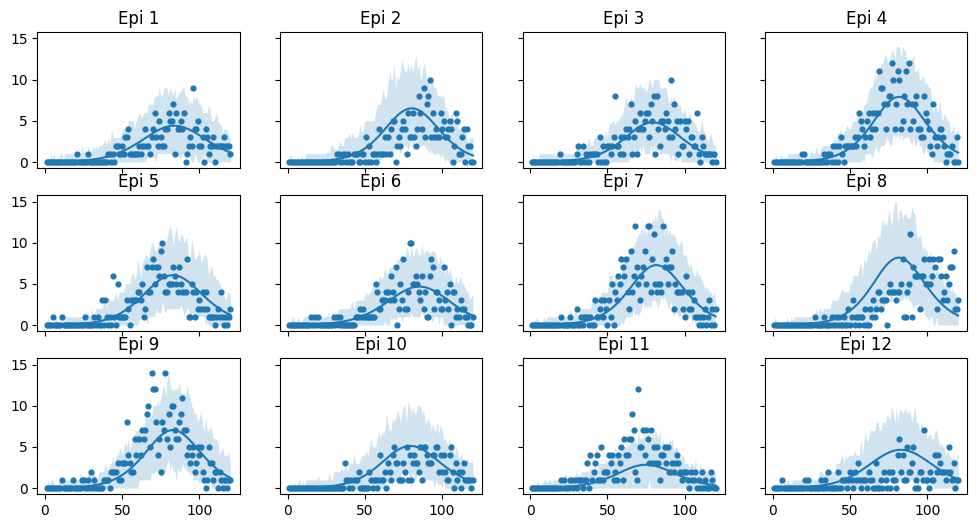

In [6]:
sim_data, sim_draws = sims[-1] ## pick one of the simulated data sets
state_var_names = ["C"]
fig = hbm.init_check(sim_data, state_var_names=state_var_names, ppd="envelope")

## Now fit the model

The `sample` method passes keyword arguments to the `sample` method from `cmdstanpy`. It is a good idea to choose a small `step_size` (which is used as an initial step size for HMC), otherwise you might ruin your carfully chosen initial parameter guess instantly. Increase `threads_per_chain` to the number of units if you have a large computer.

In [7]:
hbm.sample(
    sim_data, chains=1, threads_per_chain=R,
    step_size=0.01, refresh=1,
    iter_sampling=300, iter_warmup=300
)

10:58:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

11:00:15 - cmdstanpy - INFO - CmdStan done processing.
11:00:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: neg_binomial_2_lpmf: Location parameter is -1.10936e-08, but must be positive finite! (in 'seir_model.stan', line 74, column 8 to column 55) (in 'seir_model.stan', line 155, column 12 to column 58)
Consider re-running with show_console=True if the above output is unclear!


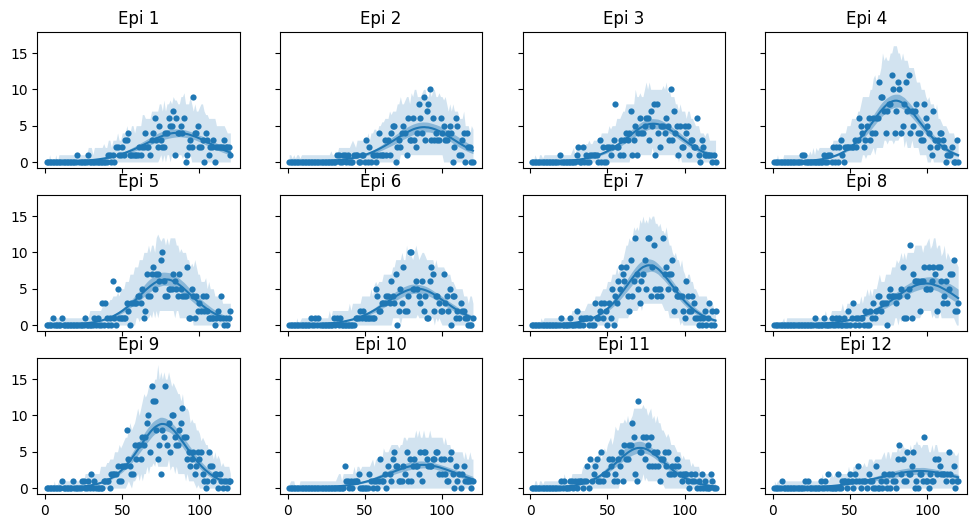

In [8]:
# check out the fits...

fig = hbm.post_pred_check(sim_data, state_var_names=['C'], ppd="envelope")

## Look at the parameter estimates

The CmdStanPy fit object can be found in `hbm.fit`. The method `stan_variable` extracts the trace of a single parameter, while `stan_variables` extracts a python `dict` with all samples. You might explore further statistics with the `arviz` package. For instance, the generated quantity `log_lik` contains the log-likelihood of all observations and can be used for model comparison, using `arviz.loo` and `arviz.compare`.

The method simulate returns a list of pairs of simulated data sets and the corresponding random parameter draws, both in a dictionary. We can now compare the conditional distribution of the random parameters with the ground-truth values.

Text(0, 0.5, '$\\gamma$')

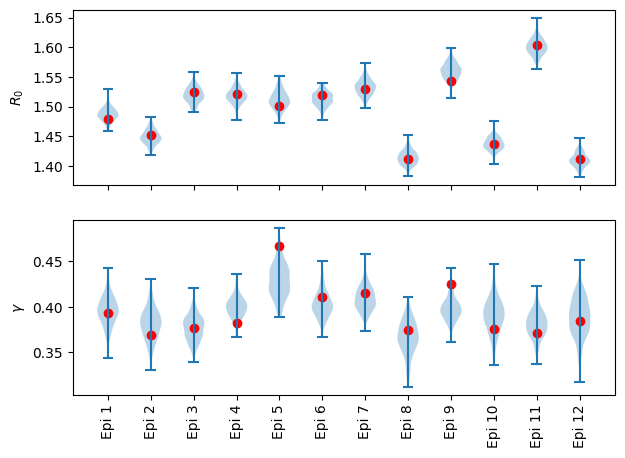

In [9]:
R0m1_hats = hbm.fit.stan_variable("R0m1")
gamma_hats = hbm.fit.stan_variable("gamma")

R0m1_gt = sim_draws["R0m1"]
gamma_gt = sim_draws["gamma"]

fig, axs = plt.subplots(2, 1, figsize=(7,5), sharex=True)

pos = list(range(R))
axs[0].violinplot(R0m1_hats + 1, positions=pos)
axs[0].scatter(pos, R0m1_gt + 1, color='r')

axs[1].violinplot(gamma_hats, positions=pos)
axs[1].scatter(pos, gamma_gt, color='r')

axs[1].set_xticks(pos)
axs[1].set_xticklabels(ID, rotation=90)

axs[0].set_ylabel("$R_0$")
axs[1].set_ylabel("$\\gamma$")

## Vaccination coverage

In the posterior predictive checks above, we could also include the variable $V$, which corresponds to the total fraction of vaccinated individuals. However, $V \in [0,1]$ and the observed cases are much larger, so we'll plot $V$ separately. The variable $V$ should pretty much correspond to the vaccination data. However, in the model we only vaccinate $S$-individuals, and the rate is per-capita, so there might be some discrepancies. 

Text(0, 0.5, 'total fraction vaccinated')

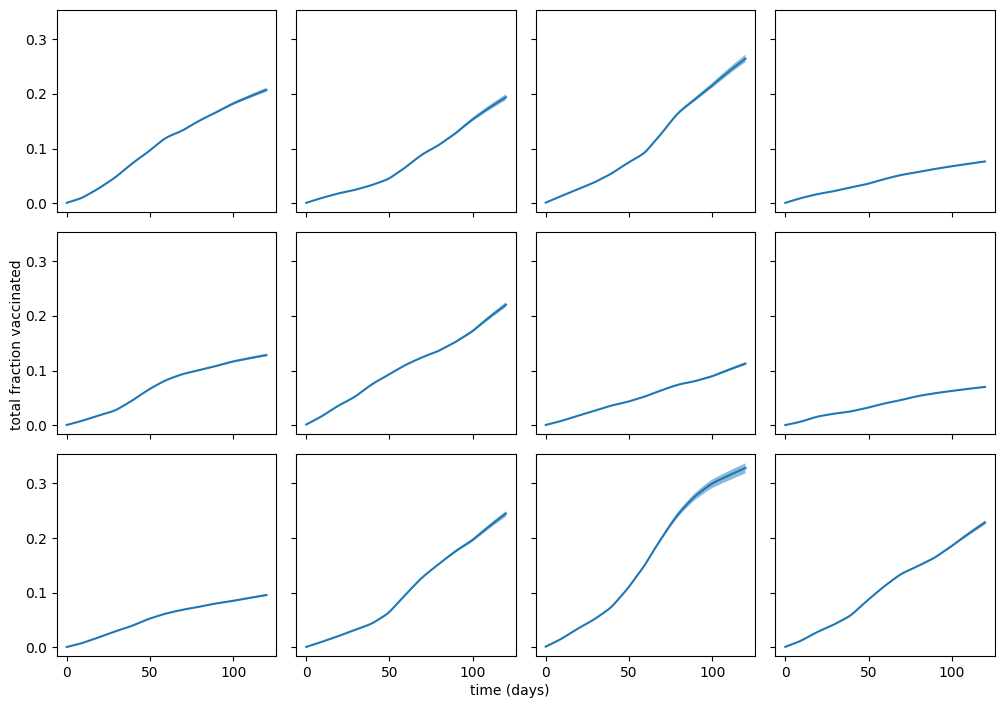

In [10]:
fig, axs = plt.subplots(3, 4, figsize=(10,7), sharex=True, sharey=True)

for r, ax in enumerate(axs.flatten()):
    Vsim = hbm.fit.stan_variable("V_sim")[:,r,...]
    Vsim_mean = np.mean(Vsim, axis=0)
    Vsim_lo, Vsim_hi = np.percentile(Vsim, axis=0, q=[2.5, 97.5])
    tsim = np.linspace(0, 120, Vsim.shape[1])
    ax.plot(tsim, Vsim_mean)
    ax.fill_between(tsim, Vsim_lo, Vsim_hi, alpha=0.5, linewidths=0)
    
fig.tight_layout()

fig.text(0.5, 0, "time (days)", ha='center')
fig.text(0, 0.5, "total fraction vaccinated", rotation=90, va='center')